<h1>Twee laagsheid en grondwaterstroming</h1>

# Initialisatie
Hier worden packages ingelezen en voorkeuren ingesteld.

In [1]:
# algemene packages
import sys
import os

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from collections import defaultdict

In [2]:
import timml as tml
# functies importeren uit timml_levee_func.py
import timml_levee_func as tlf

Printen van enkele basis gegegevens. Zo is later makkelijker duidelijker hoe het script gerund is.

In [3]:
import misc_func as mf
mf.look()

python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:00:38) [MSC v.1934 64 bit (AMD64)]
vandaag is  2023-04-21
environment env20230330 in folder C:\Users\HMEUW\Anaconda3\envs\env20230330
gebruiker HMEUW op computer LAP-0791
os           version: geen nummer  maps to C:\\Users\\HMEUW\\Anaconda3\\envs\\env20230330\\lib\\os.py
plt          version: geen nummer  maps to C:\\Users\\HMEUW\\Anaconda3\\envs\\env20230330\\lib\\site-packages\\matplotlib\\pyplot.py
np           version: 1.23.5       maps to C:\\Users\\HMEUW\\Anaconda3\\envs\\env20230330\\lib\\site-packages\\numpy\\__init__.py
pd           version: 1.5.3        maps to C:\\Users\\HMEUW\\Anaconda3\\envs\\env20230330\\lib\\site-packages\\pandas\\__init__.py
tml          version: 6.0.1        maps to C:\\Users\\HMEUW\\Anaconda3\\envs\\env20230330\\lib\\site-packages\\timml\\__init__.py
tlf          version: geen nummer  maps to D:\\python\\wss_on_github\\tim-groundwater\\Examples\\equivalent-permeability-aquifer-levee\\t

# Inleiding

Rijkswaterstaat heeft met HKV onderzoek gedaan naar het tweelagensysteem bij piping (HKV, PR4799.10, januari 2023). Dit is een vervolg op eerder onderzoek door Romeijn (2022)

## Korte samenvatting van wat vooraaf ging (Romeijn 2022)
> In de huidige rekenmethode voor tweelagensystemen wordt gebruik gemaakt van een equivalente doorlatendheid, die gebruikt kan worden in de (éénlaags) rekenregel van Sellmeijer. Deze equivalente doorlatendheid is het gewogen gemiddelde van de twee doorlatendheden, gewogen naar laagdikte.

> 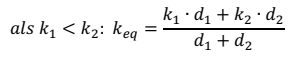

> Bij een groot contrast tussen de doorlatendheden en een grote dikte van de grove laag, leidt dit tot een relatief laag kritiek verval.

> Naast een literatuuronderzoek is een modelstudie uitgevoerd met behulp van het grondwatermodel “D-Geo Flow” (DGF). Hiertoe is een set D-Geo Flow sommen opgezet, waarin variaties in doorlatendheden en diktes van de twee lagen in een tweelagensysteem zijn toegepast. Voor iedere configuratie is de equivalente doorlatendheid berekend. Dit is de doorlatendheid in een éénlaagsmodel die tot hetzelfde kritiek verval leidt als het tweelagenmodel met twee doorlatendheden. Hieruit volgt een aanzienlijke dataset met simulaties die gebruikt is in de voorliggende studie.

> 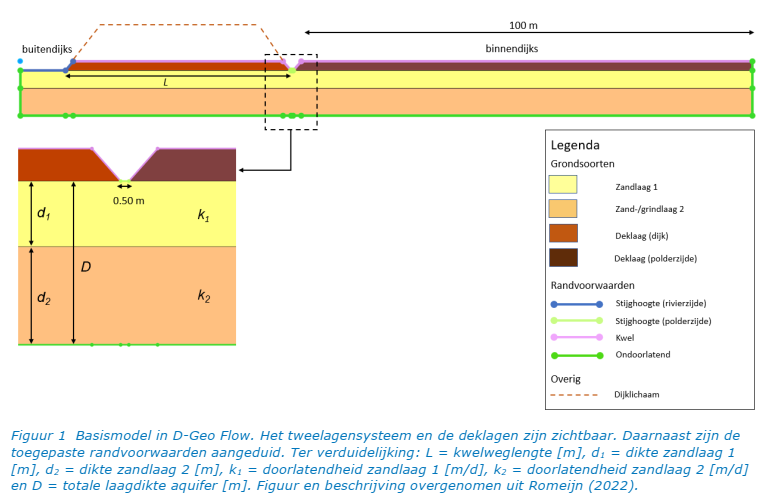

> Binnen het stageonderzoek is op de resultaten van de dataset een regressiemodel gefit die een betere voorspelling van de equivalente doorlatendheid geeft (ten opzichte van de ‘gewogen gemiddelde’ methode). Deze fit is uitgewerkt in drie stappen/formules waarvan elke stap zijn eigen toepassingsbereik heeft.

## Vervolg HKV, rapportage januari 2023

> Ondanks dat deze fits binnen de dataset goede resultaten produceren, zijn de formules vrij complex en hebben geen fysische onderbouwing. Daarom hebben wij de dataset van het onderzoek als startpunt genomen, om hiermee een nieuwe relatie af te leiden voor de equivalente doorlatendheid die beter aansluit bij de fysica.

### Concept

> Voor de alternatieve methode om een equivalente doorlatendheid te bepalen die toegepast kan worden binnen Sellmeijer, hebben we gebruik gemaakt van een analogie met bestaande concepten en formules uit het Technisch rapport waterspanningen bij dijken TRWD voor een watervoerend pakket met minder doorlatende deklaag (zie bijlage A). De voorgestelde methode beschouwt het tweelagensysteem, waar elke laag een bepaald debiet kan vervoeren. We veronderstellen dat al het berekende debiet naar de pipe stroomt en bijdraagt aan de erosie van de pipe, en dus een indicator is voor het kritiek verval. Dit is een conservatieve aanname, omdat er enig debiet naar het achterland zal wegstromen, en een deel van het debiet pas dicht bij het uittredepunt in de pipe zal komen en dus niet bijdragen aan de erosie.

> 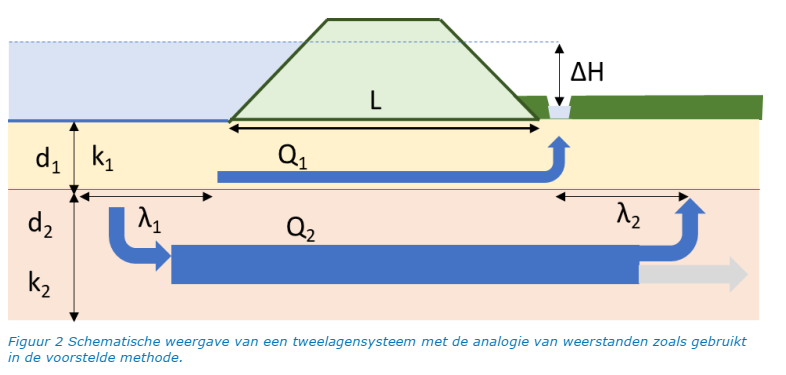

> 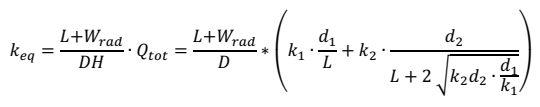

# Gegevens
Gegevens van de cases uit HKV rapportage januari 2023 ingelezen. Dat zijn de tabellen met parameters, en de resultaten in de rapportage.

In [4]:
df_hkv_cases = pd.read_excel(r'data\data_hkv_rapport.xlsx',
                       sheet_name='cases',
                       index_col=0,
                      )
df_hkv_cases

,Parameter,Eenheid,Limburg,Zeeland,Rivierengebied
id,,,,,
L,Kwelweglengte,m,45.00,75.00,60.00
d1,Dikte bovenste aquifer,m,10.00,10.00,5.00
d2,Dikte onderste aquifer,m,30.00,25.00,50.00
k1,Doorlatendheid bovenste aquifer,m/dag,10.00,5.00,10.00
k2,Doorlatendheid onderste aquifer,m/dag,200.00,25.00,50.00
k_dek_al,Doorlatendheid deklaag achterland,m/dag,0.01,0.01,0.01
d70_1,d70 bovenste aquifer,μm,180.00,100.00,200.00
keq_avg,keq gewogen gemiddelde,m/dag,153.00,19.30,46.40
keq_hkv,keq methode afgeleid door HKV,m/dag,64.60,15.00,39.30


Formules uit rapportage als functie gedefinieerd.

In [5]:
def keq_avg(k1,d1,k2,d2):
    return ( (k1*d1) + (k2*d2) ) / (d1 + d2)

def keq_hkv(k1, d1, k2, d2, L, H, fWrad, Q1=None, Q2=None, return_full=False):
    # preparation
    D = d1 + d2
    lambda1 = np.sqrt(k2 * d2 * (d1 / k1 ))
    lambda2 = lambda1
    if Q1 is None:
        # Q1 is keyword argument, because it will be calculated by TTim later
        Q1 = k1 * (d1/L) * H
    if Q2 is None:
        # Q2 is keyword argument, because it will be calculated by TTim later
        Q2 = k2 * (d2 / (lambda1 + L + lambda2) ) * H
    Qtot = Q1 + Q2
    Wrad = fWrad*D
    
    # calculate keq
    keq = ( (L + Wrad) / (D * H) ) * Qtot
    
    if return_full:
        return keq, D, lambda1, lambda2, Q1, Q2, Qtot, Wrad
    else:
        return keq

Controle van ingevoerde formules. Loop over kolom 2 en verder, want kolom 1 heeft de eenheden.

In [6]:
for case in df_hkv_cases.columns[2:]:
    
    # bereken keq_avg
    keq_avg_calc = keq_avg(k1=df_hkv_cases.loc['k1',case], d1=df_hkv_cases.loc['d1',case],
                           k2=df_hkv_cases.loc['k2',case], d2=df_hkv_cases.loc['d2',case]
                          )
    H = 1
    keq_hkv_calc = keq_hkv(k1=df_hkv_cases.loc['k1',case], d1=df_hkv_cases.loc['d1',case],
                           k2=df_hkv_cases.loc['k2',case], d2=df_hkv_cases.loc['d2',case],
                           L =df_hkv_cases.loc['L',case], H=H, fWrad=0.88)

    keq_avg_rap = df_hkv_cases.loc['keq_avg',case]
    keq_hkv_rap = df_hkv_cases.loc['keq_hkv',case]
    print(f'{case} | keq gewogen rapport:{keq_avg_rap:0.1f}, berekend:{keq_avg_calc:0.1f} | keq methode HKV rapport: {keq_hkv_rap:0.1f}, berekend: {keq_hkv_calc:0.1f} m/dag')

Limburg | keq gewogen rapport:153.0, berekend:152.5 | keq methode HKV rapport: 64.6, berekend: 64.6 m/dag
Zeeland | keq gewogen rapport:19.3, berekend:19.3 | keq methode HKV rapport: 15.0, berekend: 15.0 m/dag
Rivierengebied | keq gewogen rapport:46.4, berekend:46.4 | keq methode HKV rapport: 39.3, berekend: 39.3 m/dag


# Grondwaterstroming en debiet door TIMML

## Doel
Het eerste doel is om een vergelijking te maken met het berekende debiet in TIM en door HKV. 

Vervolgens biedt modellering in TIM mogelijkheden om de situatie nader te analyseren, bijvoorbeeld:
* analyseren wat de bijdrage is van de tweede zandlaag in de stroming naar de teensloot/pipe 
* andere randvoorwaarden wat betreft de doorsnijding van het buitenwater en de interactie met het achterland

## Opbouw model
Het model wordt opgebouwd via de invoer van verschillende parameters in Excel. Een kolom in Excel is de invoer voor een model. Het Excel bestand wordt ingelezen als een Pandas Dataframe. Scenario's kunnen worden gemaakt door het kopieren van kolommen in Excel, of het toevoegen van kolommen aan de Dataframe.

## TIMML model maken
We maken een TIMML model voor een scenario.

### Model invoer openen uit Excel

In [7]:
fn_xls = 'data\input-gwmodel.xlsx'
sheet_name = '20230421'
scen = 'rivgeb_hkv'

df_model_input = tlf.import_model_parameters(fn_xls, sheet_name)

### TimML model aanmaken en doorrekenen

In [8]:
ml = tlf.create_xsection_model(df_model_input, scen)

### Doorsnede plot maken

Je ziet:
* met de contouren de isohypsen lijnen
* de stippen geven de elementen (HeadLineSink1D) weer die de randvoorwaarden vormen:
  * donkerblauw: het zomerbed, hier tot aan de dijk
  * blauw: de uiterwaarden, hier 1 m breed
  * bordeaurood: de teensloot
  * rood: de grondwaterstand in het achterland, een samenspel van waterlopen en perceelsdrainage
* de 'tri makers' geven in dezelfde kleur als de stippen weer welke waterstand in elke stip is opgelegd
* helemaal rechts is in de bovenste modellaag van het watervoerende pakket nog net een groene diamant zichtbaar. Hier is een constante waterstand opgelegd. TimML vereist een zo'n punt in het model. Dit schematiseert meteen dat er op de rechter rand van het model nog een stijghoogte druk aanwezig is.
* donkergrijs gestippeld: de hoofdpakketten: deklaag, eerste WVP en tweede WVP
* dunne grijze lijnen: de modellagen in TimML
* de dikke groene lijn is de locatie van de waterkering. Deze is verder niet in het TimML model opgenomen, wordt wel weergegeven voor een logisch overall beeld.

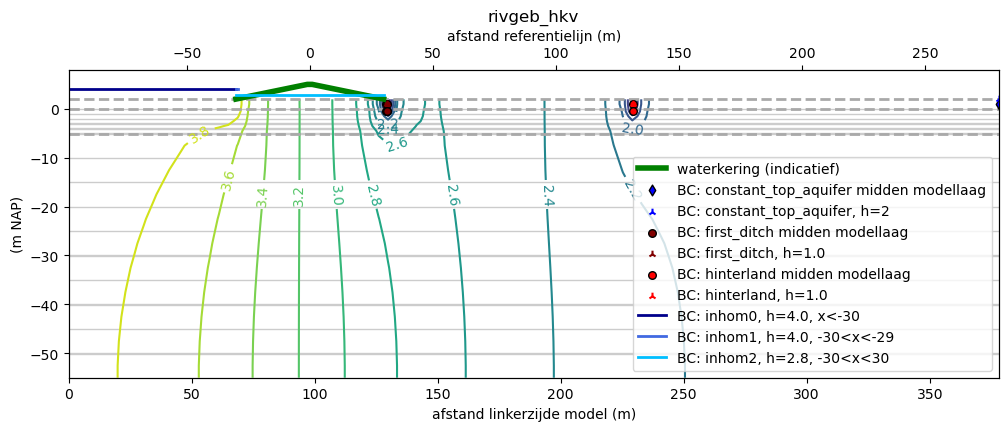

In [9]:
tlf.plot_contour(ml, df_model_input, scen=scen, dh=0.2)

### Berekende stijghoogte op verschillende niveaus
Onderstaande plot geeft weer welke stijghoogte er op verschillende niveaus is berekend. Gekozen is voor de volgende niveaus:
* blauw: in de deklaag
* oranje: de bovenste modellaag van het 1e watervoerende pakket
* groen: de bovenste modellaag van het 2e watervoerende pakket
* rood: de onderste modellaag, dat is onderin het 2e watervoerende pakket

In de plot zijn via lijnen en 'tri makers' ook de opgelegde waterstanden weergegeven.

Voor het begrip van het model is de modelopbouw van belang.

De randvoorwaarden voor het buitenwater, voorland en dijk zijn opgelegd via een inhomogeniteit met een weerstand en waterstand. De interactie tussen deze elementen en het grondwater hangt af van de bodemweerstand en in welke laag het element is opgelegd. Het buitenwater en teensloot snijden in dit model de bovenzijde van het watervoerende pakket aan. Voor het voorland geldt dat deze elementen in de deklaag zijn opgelegd. De deklaag heeft zelf een bepaalde doorlatendheid.

(<Figure size 1200x400 with 1 Axes>,
 <Axes: xlabel='afstand (m ref)', ylabel='(m NAP)'>)

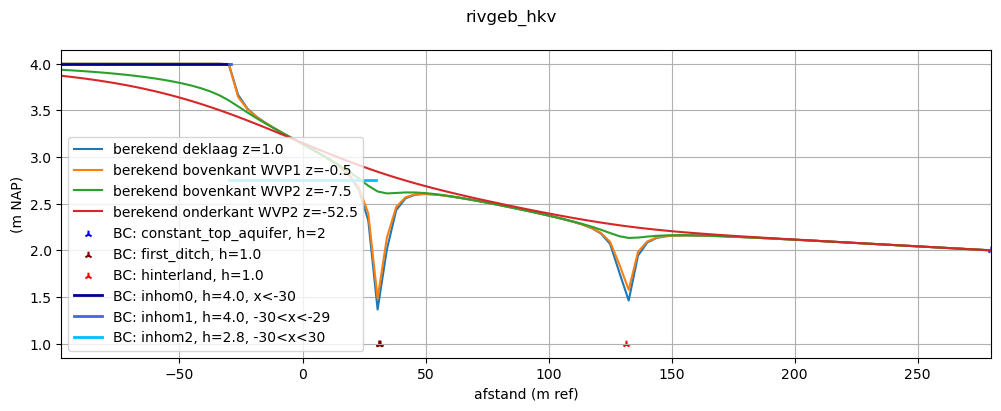

In [10]:
tlf.plot_h(ml, df_model_input, scen)

### Verloop van de debieten
De vraag voor het model was inzicht geven in de debieten. Daarvoor is onderstaande plot opgenomen. 

De bovenste figuur geeft via de lijn het verloop van de grondwaterstroming plaats. Hiervoor is het model uitgelezen op dezelfde niveaus als in bovenstaande stijghoogte plot. Als voorbeeld: 
* de groene lijn geeft weer hoeveel grondwater er in de x-richting stroomt aan de bovenzijde van het 2e watervoerende pakket.
    * Onder het buitenwater (tot circa x=-30) neemt deze stroming toe. 
    * Onder de buitenberm is de stroming enigszins stabiel. 
    * Tussen de kruin (x=0) en de teensloot (circa x=30) neemt de stroming toe.
    * Tot aan de teensloot is de stroming positief: het water stroomt van het buitenwater naar de teensloot.
    * Direct rechts van de teensloot is de stroming negatief: het water stroomt vanuit het achterland naar de teensloot.
* de rode lijn geeft de stroming aan de onderzijde van het watervoerende pakket weer. Deze stroming neemt tussen x=0 en x=50 af. In dat gebied neemt de groene lijn juist toe. Of te wel: de bovenzijde van het watervoerende pakket draineert daar de onderzijde van hetzelfde pakket.

De tweede figuur geeft de stroming tussen modellaagen weer. De kleuren zijn dezelfde dieptes als in de eerste figuur.

De onderste 4 figuren geven op 4 locaties een doorsnede van de stroming over alle modellagen. De blauwe stippen geven de stroming per modellaag weer. De blauwe lijnen geven de som per watervoernend pakket weer. De gekleurde stippellijnen zijn de niveaus waarop het model in de bovenste figuur is uitgelezen.

De figuur laat zien dat het meerendeel van de grondwaterstroming via het 2e watervoerende pakket plaatsvindt. Vergelijk daarvoor bijvoorbeeld de doorsnede op x=0. De grondwaterstroming is daar 0.5 tov 22.8.

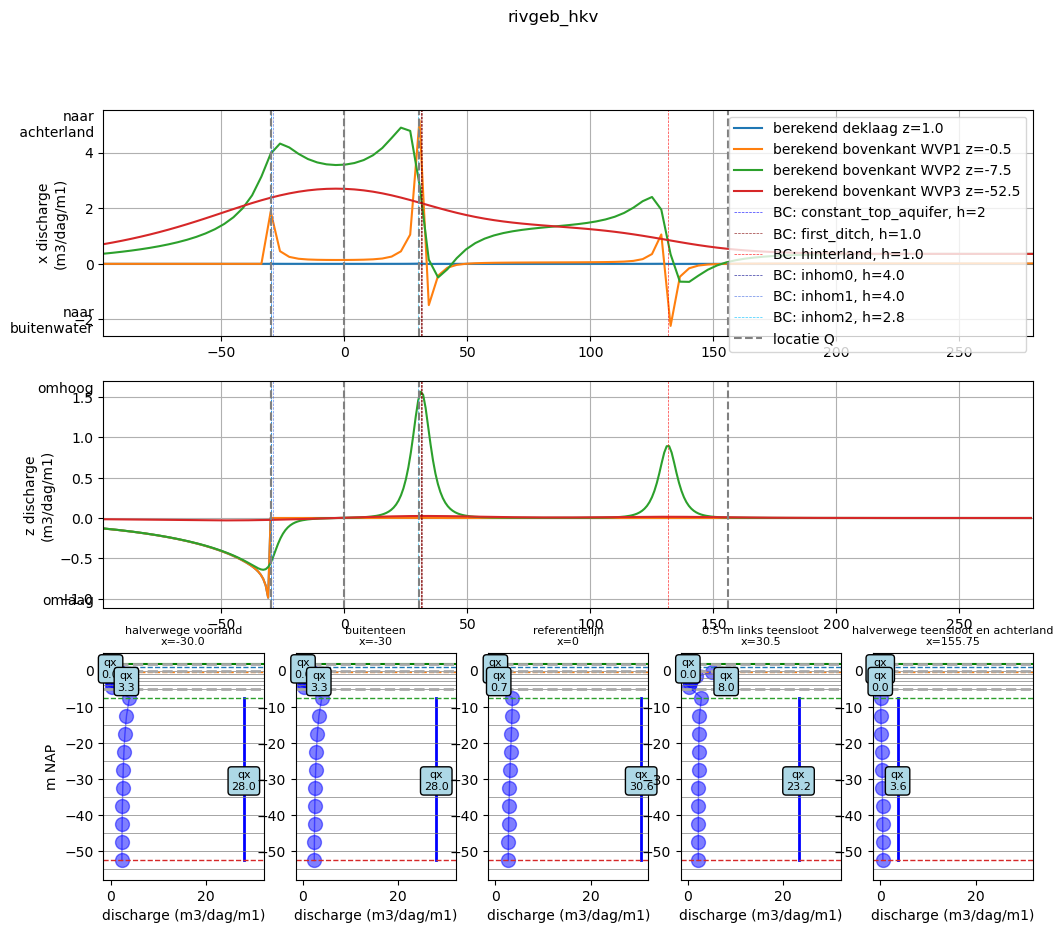

In [11]:
fig, ax, all_qx = tlf.plot_q_and_disvec(ml, df_model_input, scen,)

In de volgende plot is ingezoomd op de bovenkant van het watervoerende pakket. Via `plot_layers` is aangegeven welke lagen worden weergegeven.

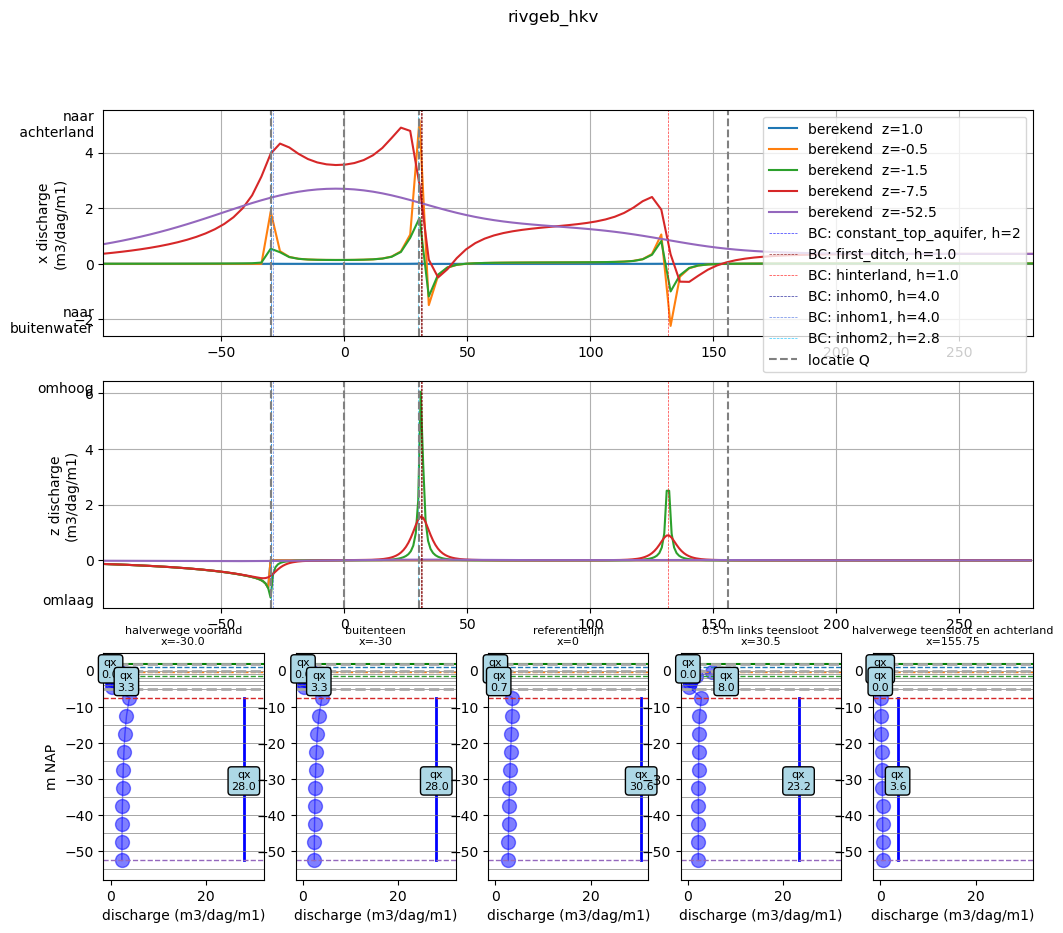

In [12]:
fig, ax, all_qx = tlf.plot_q_and_disvec(ml, df_model_input, scen, plot_layers=[0,1,2,6, 15])

### Vergelijking met keq door HKV
Hoe passen deze debieten bij debiet van HKV? 

Hieronder de formule herhaald. HKV berekent een debiet van 20 m3/dag/m1 in totaal. De verhouding tussen het eerste en tweede deel van het watervoerende pakket is 4.4%.

In [13]:
keq, D, lambda1, lambda2, Q1, Q2, Qtot, Wrad = keq_hkv(k1=df_hkv_cases.loc['k1','Rivierengebied'], d1=df_hkv_cases.loc['d1','Rivierengebied'],
        k2=df_hkv_cases.loc['k2','Rivierengebied'], d2=df_hkv_cases.loc['d2','Rivierengebied'],
        L=df_hkv_cases.loc['L','Rivierengebied'], H=1, 
        fWrad=0.88, Q1=None, Q2=None, return_full=True)
    
print(f'keq {keq:0.1f}')
print(f'Q1 {Q1:0.1f}; Q2 {Q2:0.1f}; Q tot {Q1+Q2:0.1f}')
print(f'Q1 tov Q2 {(Q1/Q2)*100:0.1f} (%)')

keq 39.3
Q1 0.8; Q2 19.1; Q tot 20.0
Q1 tov Q2 4.4 (%)


In het TIMML model is de totale grondwaterstroming hoger (31.3 tov 20 m3/dag/m1).

In [14]:
# uit welke modellagen bestaat iedere watervoerend pakket?
lst_first_layer_per_aquifer, lst_last_layer_per_aquifer = tlf.get_layers_per_aquifer(ml)

# afvoer berekenen
qx_reflijn = all_qx[3]
qx_reflijn_wvp1 = qx_reflijn[lst_first_layer_per_aquifer[1]:lst_last_layer_per_aquifer[1]+1].sum()
qx_reflijn_wvp2 = qx_reflijn[lst_first_layer_per_aquifer[2]:lst_last_layer_per_aquifer[2]+1].sum()

# printen
print(f'Q1 {qx_reflijn_wvp1:0.1f}; Q2 {qx_reflijn_wvp2:0.1f}; Q tot {qx_reflijn_wvp1+qx_reflijn_wvp2:0.1f}')
print(f'Q1 tov Q2 {(qx_reflijn_wvp1/qx_reflijn_wvp2)*100:0.1f} (%)')

Q1 3.3; Q2 28.0; Q tot 31.3
Q1 tov Q2 11.9 (%)


### Tracelines, stroomlijnen
Kan natuurlijk ook, maar werkt nog niet geweldig voor een doorsnede model. Iets om aan te werken.

.......

C:\Users\HMEUW\Anaconda3\envs\env20230330\lib\site-packages\timml\util.py:225: FutureWarning: In a future version traces will be returned as a dictionary containing metadata together with the trace. To already get the new behavior use metadata=True.
  trace = timtraceline(


..................


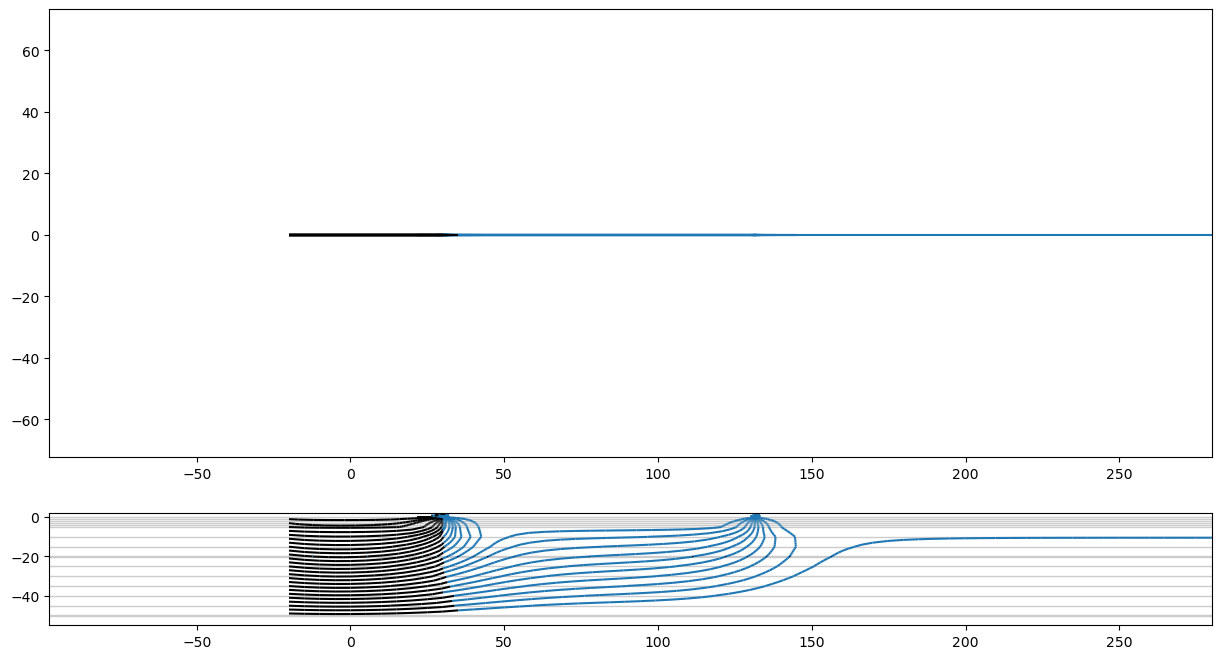

In [15]:
win = [df_model_input.loc['x_channel_max', scen], 
       df_model_input.loc['x_hinterland_max', scen],
       0, 1]

dh = 1

zstart = np.arange(-1,-50,-2)
xstart = np.ones_like(zstart) * -20
ystart = np.zeros_like(zstart)

hstepmax=1

ml.plot(win=win, orientation='both', figsize=(15,8))
tr = ml.tracelines(xstart=xstart, ystart=ystart, zstart=zstart, 
              hstepmax=5, tmax=1000, orientation='both', color='C0',
                  return_traces=True)

# Alles in een stap.
Hierboven zijn alle plots los gemaakt en beschreven. Via onderstaande overall formule wordt alles in een keer berkend.

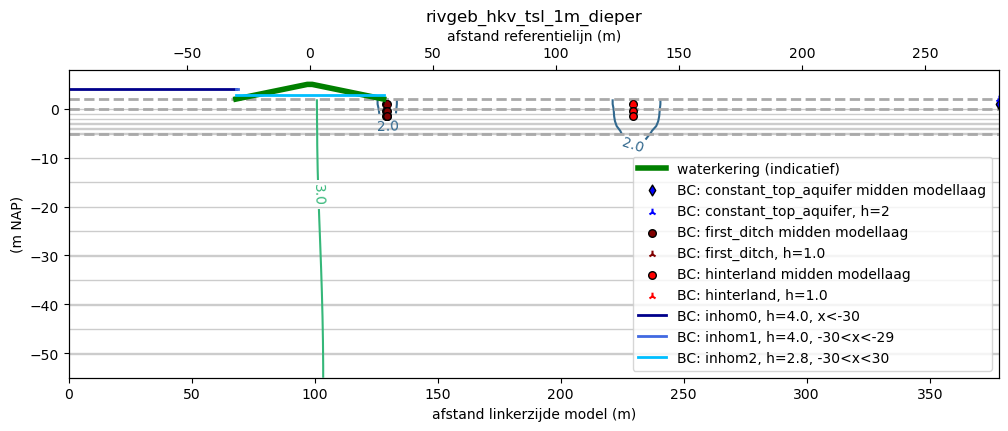

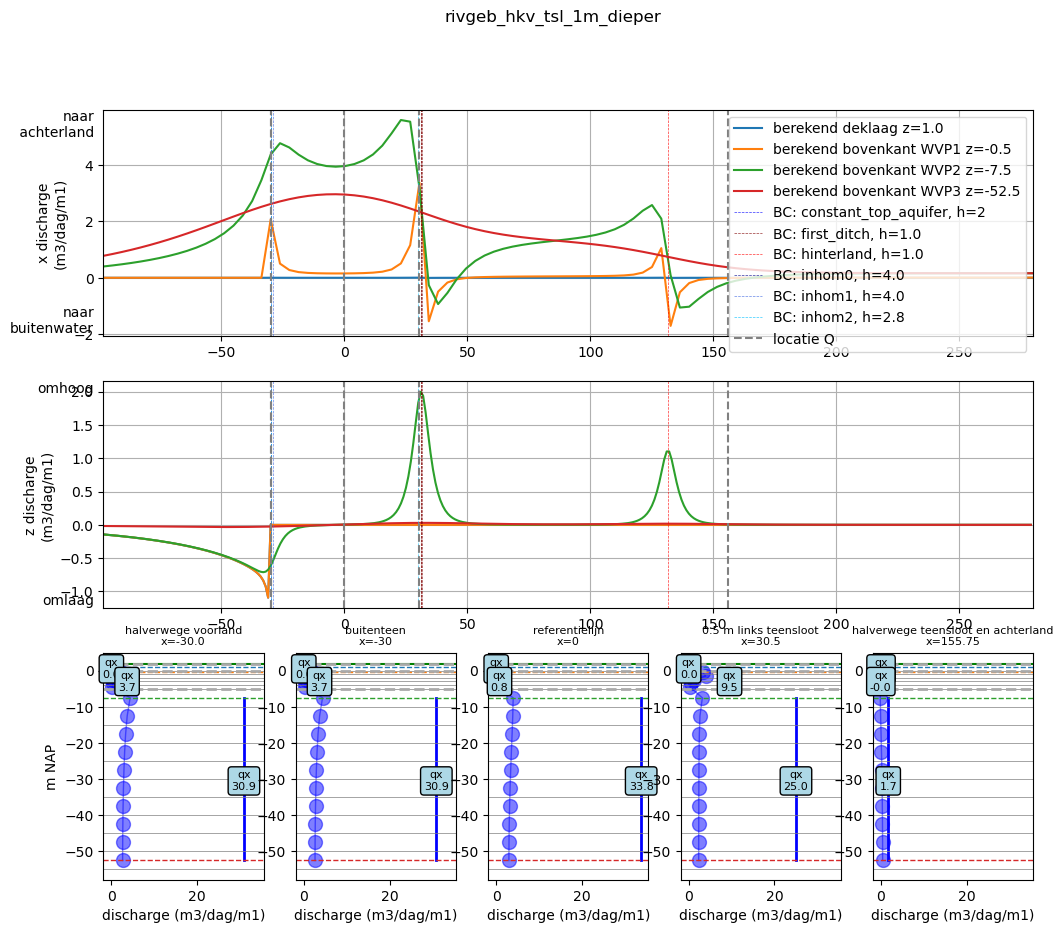

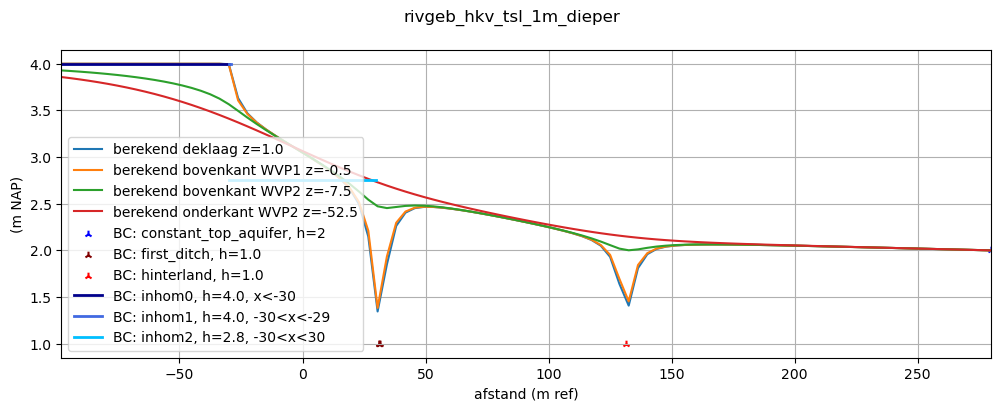

In [16]:
# nieuw scenario
this_scen = f'{scen}_tsl_1m_dieper'

# nieuwe kolom in DataFrame
df_model_input[this_scen] = df_model_input[scen]
# teensloot 1 m dieper
df_model_input.loc['bottom_ditch', this_scen] = df_model_input.loc['bottom_ditch', this_scen] - 1

# model doorrekenen en plotten
tlf.create_plot_model(df_model_input, this_scen, dh=1, close_plot=False);


# Gevoeligheidsanalyse
Voorbeeld van gevoeligheidsanalyse voor diepte teensloot. Deze 1 m minder diep maken, gelijk en een meter dieper.

In [17]:
base_scen = 'rivgeb_hkv'
parameter = 'bottom_ditch'
factors_add = [1, 0, -1]

df_q = tlf.sensitity_one_parameter(df_model_input, base_scen=base_scen, parameter=parameter, factors_add=factors_add, verbose=False)
df_q

,name,factor_multiply,factor_add,q_bc_ditch,q_bc_hinterland,q_refline_dek,q_refline_WVP1,q_refline_WVP2,q_refline_WVP_perc,q_refline_array
0,rivgeb_hkv_run_bottom_ditch_m1_a1,1,1,0.1,0.1,0.0,1.4,11.9,12.1,"[0.0010239012161757997, 0.8920529596320366, 0...."
1,rivgeb_hkv_run_bottom_ditch_m1_a0,1,0,17.6,10.1,0.0,3.1,25.6,12.1,"[0.0021995648428738018, 1.928697377313368, 0.5..."
2,rivgeb_hkv_run_bottom_ditch_m1_a-1,1,-1,21.1,11.8,0.0,3.4,28.3,12.1,"[0.002428792691243769, 2.1308156232943043, 0.5..."


Anisotropie varieren

In [18]:
base_scen = 'rivgeb_hkv'
parameter = 'kzoverkh_per_aquifer'
factors_multiply = [1, 4, 10]

df_q = tlf.sensitity_one_parameter(df_model_input, base_scen=base_scen, parameter=parameter, factors_multiply=factors_multiply, factors_add=None)
df_q

,name,factor_multiply,factor_add,q_bc_ditch,q_bc_hinterland,q_refline_dek,q_refline_WVP1,q_refline_WVP2,q_refline_WVP_perc,q_refline_array
0,rivgeb_hkv_run_kzoverkh_per_aquifer_m1_a0,1,0,17.6,10.1,0.0,3.1,25.6,12.1,"[0.0021995648428738018, 1.928697377313368, 0.5..."
1,rivgeb_hkv_run_kzoverkh_per_aquifer_m4_a0,4,0,9.2,6.1,0.0,2.2,17.5,12.4,"[0.0016018968365783986, 1.3447409123249092, 0...."
2,rivgeb_hkv_run_kzoverkh_per_aquifer_m10_a0,10,0,5.8,4.1,0.0,1.7,13.5,12.9,"[0.001297687185233217, 1.0757091340294551, 0.2..."


# Andere geometrie buitendijks

## Rivierengebied

HKV schematisatie is zonder een voorland. In aparate kolom in Excel dit gewijzigd. 

Nu een zomerbed gedefinieerd dat insnijdt in watervoerende pakket; én een voorland dat overstroomt. Oranje cellen in Excel geven aan wat gewijzigd is. Het voorland heeft interactie met het watervoerende pakket via de slecht doorlatende deklaag (eerste waarde in kh_aquifers samen met kzoverkh_aquifers).

Het resultaat is dat de stroming in WVP1 sterk afneemt. De storming in WVP2 blijft vergelijkbaar.

debiet op referentielijn (x=0): WVP1=3.1, WVP2=25.6, percentage=12.1


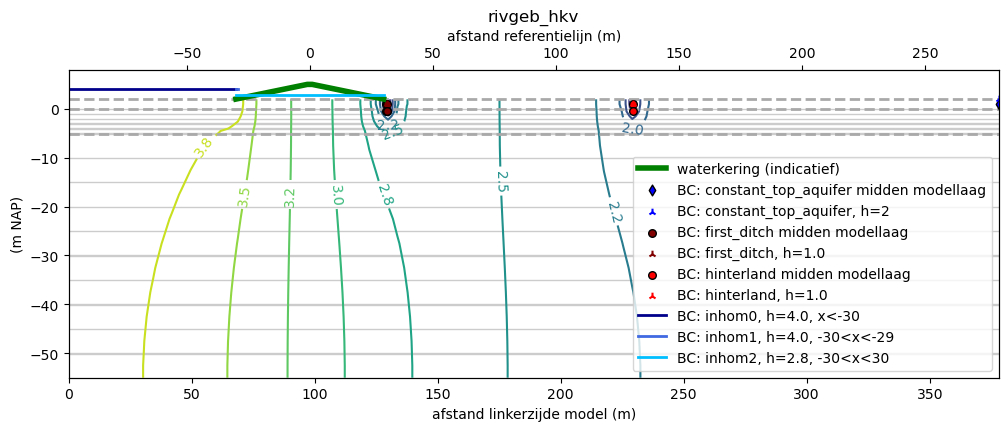

In [19]:
scen = 'rivgeb_hkv'
ml, q_names, q_values, lst_lay_first, lst_lay_last = tlf.create_plot_model(df_model_input, scen, dh=1, close_plot=True)
tlf.plot_contour(ml, df_model_input, scen=scen, dh=0.25)
tlf.calc_q_per_aquifer(q_values, lst_first_layer_per_aquifer, lst_last_layer_per_aquifer, do_print=True);

debiet op referentielijn (x=0): WVP1=0.5, WVP2=24.3, percentage=2.2


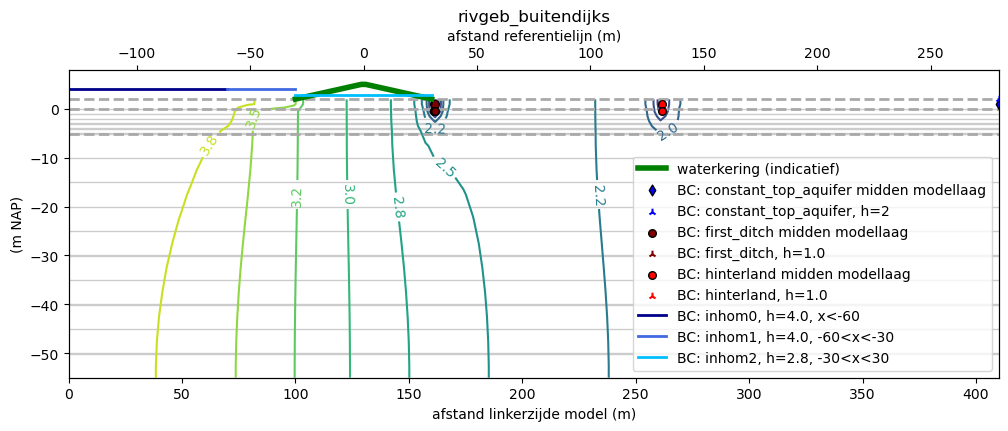

In [20]:
scen = 'rivgeb_buitendijks'
ml, q_names, q_values, lst_lay_first, lst_lay_last = tlf.create_plot_model(df_model_input, scen, dh=1, close_plot=True)
tlf.plot_contour(ml, df_model_input, scen=scen, dh=0.25)
tlf.calc_q_per_aquifer(q_values, lst_first_layer_per_aquifer, lst_last_layer_per_aquifer, do_print=True);

## Zeeland

Ook de schematisatie van Zeeland aangepast. Hier is er geen zomerbed en uiterwaard; maar de vaargeul van de Westerschelde.

Na deze aanpassing halveert het debiet in WVP1.

debiet op referentielijn (x=0): WVP1=1.4, WVP2=4.5, percentage=31.0


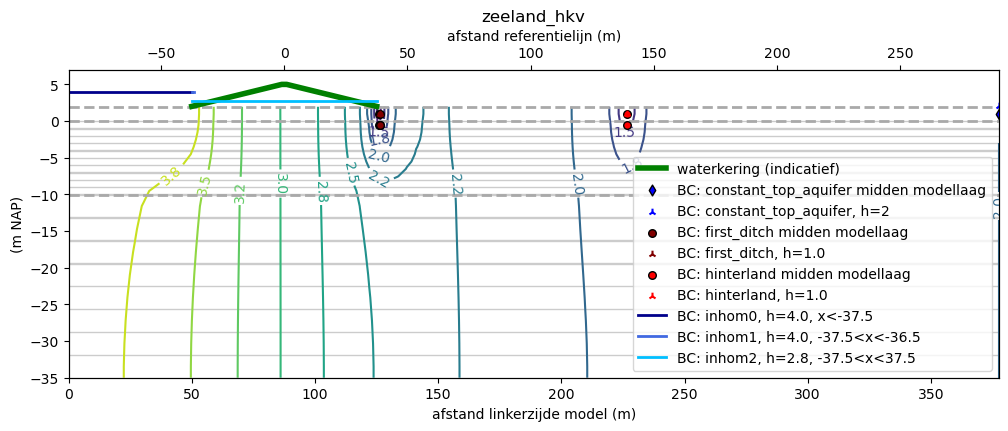

In [21]:
scen = 'zeeland_hkv'
ml, q_names, q_values, lst_lay_first, lst_lay_last = tlf.create_plot_model(df_model_input, scen, dh=1, close_plot=True)
tlf.plot_contour(ml, df_model_input, scen=scen, dh=0.25)
tlf.calc_q_per_aquifer(q_values, lst_first_layer_per_aquifer, lst_last_layer_per_aquifer, do_print=True);

debiet op referentielijn (x=0): WVP1=0.1, WVP2=0.8, percentage=7.0


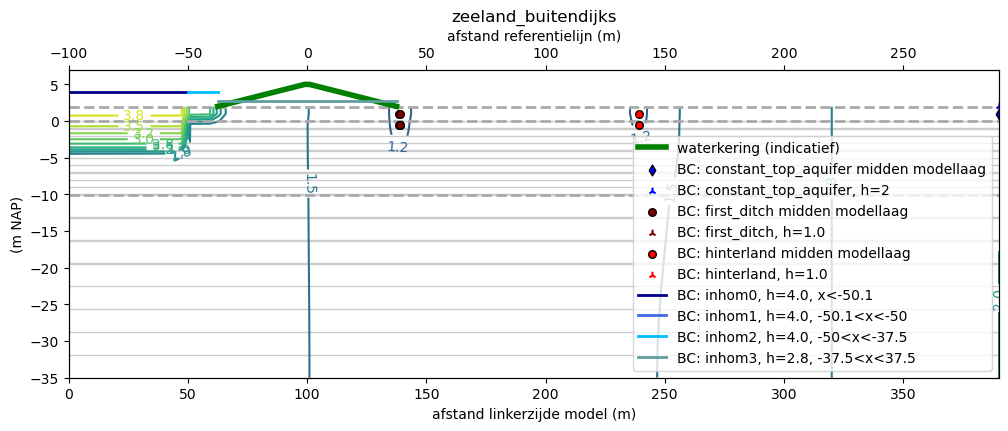

In [22]:
scen = 'zeeland_buitendijks'
ml, q_names, q_values, lst_lay_first, lst_lay_last = tlf.create_plot_model(df_model_input, scen, dh=1, close_plot=True)
tlf.plot_contour(ml, df_model_input, scen=scen, dh=0.25)
tlf.calc_q_per_aquifer(q_values, lst_first_layer_per_aquifer, lst_last_layer_per_aquifer, do_print=True);

Nu een gevoeiligheidsanalyse waarbij de diepte van de vaargeul steeds met 5 m toeneemt. De functie werkt met 'plus', dus de invoer is negatief.

Een toename van de diepte geeft een verschuiving naar het debiet naar WVP2.

In [23]:
base_scen = 'zeeland_buitendijks'
parameter = 'channel_bottom'
factors_add = [5, 0, -5, -10, -15]

df_q = tlf.sensitity_one_parameter(df_model_input, base_scen=base_scen, parameter=parameter, factors_add=factors_add, verbose=False)
df_q

,name,factor_multiply,factor_add,q_bc_ditch,q_bc_hinterland,q_refline_dek,q_refline_WVP1,q_refline_WVP2,q_refline_WVP_perc,q_refline_array
0,zeeland_buitendijks_run_channel_bottom_m1_a5,1,5,2.5,2.2,0.0,0.2,2.0,8.6,"[5.564824367361368e-05, 0.01958578434885796, 0..."
1,zeeland_buitendijks_run_channel_bottom_m1_a0,1,0,2.0,2.0,0.0,0.1,1.2,10.2,"[4.7889235928795226e-05, 0.013659798844822052,..."
2,zeeland_buitendijks_run_channel_bottom_m1_a-5,1,-5,1.8,2.0,0.0,0.1,1.1,7.4,"[3.8689215347756305e-05, 0.008617487548658376,..."
3,zeeland_buitendijks_run_channel_bottom_m1_a-10,1,-10,2.1,2.1,0.0,0.1,1.4,5.2,"[3.7589224976808615e-05, 0.008375948815806559,..."
4,zeeland_buitendijks_run_channel_bottom_m1_a-15,1,-15,2.1,2.1,0.0,0.1,1.4,4.5,"[3.589773909207425e-05, 0.007459454888769682, ..."
